# Capstone Project - Food Classifier

## Overview

The aim of this Capstone Project is to use deep learning to classify images of food. The notebook will include all implementation stages of the project including, data processing, training and building the model and finally an analysis of the results. 

## Software Requirements

The project requires an installation of Anaconda with Python 2. The main libraries use will be Keras with a Tensorflow backend, panda and numpy. 

## Data Processing

The project uses the UECFOOD256 from an academic insitute in Japan, the dataset contains 31,651 images in 256 folders with each folder being a particular category of the food.

In [1]:
from os import listdir
import os.path
import pandas as pd
from sklearn.datasets import load_files    
from sklearn.model_selection import train_test_split
import numpy as np
from shutil import copyfile
from sklearn.datasets import load_files       
from keras.utils import np_utils

raw_dataset = r'UECFOOD256'
categories = r'labels.txt' 
images_folder = r'food-images'
train_folder = os.path.join(images_folder, 'train')
valid_folder = os.path.join(images_folder, 'valid')
test_folder = os.path.join(images_folder, 'test')

def create_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
        
create_folder(images_folder)
create_folder(train_folder)
create_folder(valid_folder)
create_folder(test_folder)

labels = pd.read_csv(categories, sep=",", header=0)
num_food_labels = len(labels)

def get_label_from_raw(raw_label, labels):
    return labels.iloc[int(raw_label)-1]["name"]

Using TensorFlow backend.


### Cross validation

Currently the images are all grouped together within their labeled folders and they need to be seperated into the training, validation and testing sets for each label. First the names of the files are loaded into a collection, then train_test_split is used to obtain the training and testing set. The method is called again to further split the training data into training and validation sets.

A three folders are created: train, valid, test which each contain a subfolder with the correct label and the images from our cross validation split earlier. The methods are defined here:

In [2]:
# Function to confirm the number of files per label
def get_total_images_per_label(path):
    total = 0
    for item in listdir(path):
        image_folder = os.path.join(path, item)
        if os.path.isdir(image_folder):        
            images = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
            print('Folder ' + item + ' has ' + str(len(images)) + ' images')
            total = total + len(images)
    print('total files ' + str(total))

def train_validate_test_split(path, raw_label, labels):
    label = get_label_from_raw(raw_label, labels)
    image_folder = os.path.join(path, raw_label)
    files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]  

    X = np.vstack(files)
    y = np.vstack([label] * len(files))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        
    return X_train, X_val, X_test, y_train,  y_val, y_test

def copy_images_to_folder(src_folder, set_folder, food_label, images):
    target_folder = os.path.join(set_folder, food_label)
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
    for image in images:        
        src = os.path.join(src_folder, image[0])
        dst = os.path.join(target_folder, image[0])
        copyfile(src, dst)        
        
def split_and_transfer_raw_images(raw_dataset, labels):    
    raw_labels = [int(folder) for folder in listdir(raw_dataset) if os.path.isdir(os.path.join(raw_dataset, folder))]
    sorted_labels = sorted(raw_labels)
    for raw_label in raw_labels:
        raw_label = str(raw_label)
        X_train, X_val, X_test, y_train,  y_val, y_test = train_validate_test_split(raw_dataset, raw_label, labels) 
        food_label = raw_label + '.' + get_label_from_raw(raw_label, labels)
        src_folder = os.path.join(raw_dataset, raw_label)
        copy_images_to_folder(src_folder, train_folder, food_label, X_train)
        copy_images_to_folder(src_folder, valid_folder, food_label, X_val)
        copy_images_to_folder(src_folder, test_folder, food_label, X_test)        

The cross validation split is performed here:

In [ ]:
split_and_transfer_raw_images(raw_dataset, labels)

The data is now loaded:

In [3]:
%%time
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), len(labels))
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)
valid_files, valid_targets = load_dataset(valid_folder)
test_files, test_targets = load_dataset(test_folder)

# print statistics about the dataset
print('There are %d total food categories.' % num_food_labels)
print('There are %s total food images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training food images.' % len(train_files))
print('There are %d validation food images.' % len(valid_files))
print('There are %d test food images.'% len(test_files))

There are 256 total food categories.
There are 31395 total food images.

There are 22402 training food images.
There are 5730 validation food images.
There are 3263 test food images.
CPU times: user 452 ms, sys: 2.19 s, total: 2.64 s
Wall time: 2.65 s


### Image Resize

As we construct tensors from the images, they need to be resized order to standardize the input dimensions for the convolutional neural network. 

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

channels = 3

def path_to_tensor(img_path, pixel_size):
    img = image.load_img(img_path, target_size=(pixel_size, pixel_size))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, pixel_size):
    list_of_tensors = [path_to_tensor(img_path, pixel_size) for img_path in tqdm(img_paths) if img_path.endswith('jpg')]
#    print([img_path for img_path in tqdm(img_paths) if img_path.endswith('jpg')])
    return np.vstack(list_of_tensors)

Loading the images and rescaling them

In [5]:
%%time
             
# pre-process the data for Keras
pixel_size = 64
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:15<00:00, 206.79it/s]


CPU times: user 2min 32s, sys: 1.75 s, total: 2min 34s
Wall time: 2min 33s


After creating the tensors we can view how they've been resized:

In [5]:
from matplotlib import pyplot

In [6]:
def display_samples(tensors):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(tensors[i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()    

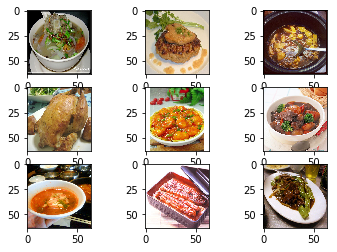

In [7]:
display_samples(train_tensors)

### Basic Classifier

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

def calculate_accuracy(model, test_tensors):
    food_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]    
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(food_predictions)==np.argmax(test_targets, axis=1))/len(food_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    return test_accuracy

def print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers):
    print('Pixel size {}, channels {}, number of conv layers {}, number of pool layers {}'
          .format(pixel_size, channels, num_conv_layers, num_pool_layers))
    
def hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix):
    return '{}.{}.conv.{}.pool.{}.hdf5'.format(prefix, pixel_size, num_conv_layers, num_pool_layers)

def compile_run_test(model, pixel_size, num_conv_layers, num_pool_layers, 
                    train_tensors, train_targets,
                    valid_tensors, valid_targets,
                    epochs = 5,
                    batch_size = 20,
                    optimizer = 'rmsprop'):
    
    # print the model summary
    model.summary()
    print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers)
    
    # create a checkpoint for recovery
    hdf5_file = hdf5_name(pixel_size, num_conv_layers, num_pool_layers, 'basic')
    checkpointer = ModelCheckpoint(filepath='saved_models/' + hdf5_file, 
                               verbose=1, save_best_only=True)
    print('Checkpoint at {}'.format(hdf5_file))
    
    # compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)
    
    model.load_weights('saved_models/' + hdf5_file)
    calculate_accuracy(model, test_tensors)

def compile_run_test_with_datagen(model, pixel_size, num_conv_layers, num_pool_layers, 
                    train_tensors, train_targets,
                    valid_tensors, valid_targets,
                    datagen,
                    epochs = 5,
                    batch_size = 20,
                    optimizer = 'rmsprop',
                    prefix = 'nozca'                      
                    ):
    
    # print the model summary
    model.summary()
    print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers)
    
    # create a checkpoint for recovery
    hdf5_file = hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix)
    checkpointer = ModelCheckpoint(filepath='saved_models/' + hdf5_file, 
                               verbose=1, save_best_only=True)
    print('Checkpoint at {}'.format(hdf5_file))
    
    # compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=32),
                        validation_data=(valid_tensors, valid_targets),
                        steps_per_epoch=len(train_tensors) / 32, 
                        epochs=epochs, callbacks=[checkpointer], verbose=1)   
    
    model.load_weights('saved_models/' + hdf5_file)
    calculate_accuracy(model, test_tensors)     

This model will run without augmentation

In [29]:
basic_model = Sequential()
num_conv_layers = 1
num_pool_layers = 1
basic_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(GlobalAveragePooling2D())
basic_model.add(Dense(num_food_labels, activation='softmax'))

In [33]:
%%time
# create a basic result without augmentation
compile_run_test(   model=basic_model, 
                    pixel_size=pixel_size, num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4352      
Total params: 4,560.0
Trainable params: 4,560.0
Non-trainable params: 0.0
_________________________________________________________________
Pixel size 64, channels 3, number of conv layers 1, number of pool layers 1
Checkpoint at basic.64.conv.1.pool.1.hdf5
Train on 22402 samples, validate on 5730 samples
Epoch 1/5
22402/22402 [==============================] - 37s - loss: 5.5109 - acc: 0.0226 - val_los

### Basic classifier with more layers

In [34]:
basic_model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
basic_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(GlobalAveragePooling2D())
basic_model.add(Dense(num_food_labels, activation='softmax'))

In [37]:
%%time
# create a basic result without augmentation but more layers
compile_run_test(   model=basic_model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 64)                0         
__________

### Basic classifiers with more pixels

In [11]:
#%%time             

pixel_size = 128
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:15<00:00, 206.52it/s]


In [12]:
basic_model_128 = Sequential()
num_conv_layers = 3
num_pool_layers = 3
basic_model_128.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model_128.add(MaxPooling2D(pool_size=(2,2)))
basic_model_128.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_128.add(MaxPooling2D(pool_size=(2,2)))
basic_model_128.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_128.add(MaxPooling2D(pool_size=(2,2)))
basic_model_128.add(GlobalAveragePooling2D())
basic_model_128.add(Dense(num_food_labels, activation='softmax'))

In [13]:
%%time
# create a basic result without augmentation but with 128 pixels
compile_run_test(   model=basic_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [ ]:
Load 256 pixels this time

In [7]:
%%time
pixel_size = 256
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:16<00:00, 196.45it/s]


CPU times: user 2min 49s, sys: 14.7 s, total: 3min 4s
Wall time: 3min 3s


In [8]:
basic_model_256 = Sequential()
num_conv_layers = 3
num_pool_layers = 3
basic_model_256.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model_256.add(MaxPooling2D(pool_size=(2,2)))
basic_model_256.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_256.add(MaxPooling2D(pool_size=(2,2)))
basic_model_256.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_256.add(MaxPooling2D(pool_size=(2,2)))
basic_model_256.add(GlobalAveragePooling2D())
basic_model_256.add(Dense(num_food_labels, activation='softmax'))

In [9]:
%%time
# create a basic result without augmentation but with 256 pixels
compile_run_test(   model=basic_model_256, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Image Augmentation

After rescaling the images, we should perform image augmentation, this involves a few processes:
* Standardization
* Whitening (ZCA)
* Random Rotations
* Random Shifts
* Random Flips

In [8]:
from keras.preprocessing.image import ImageDataGenerator 
from keras import backend as K

def display_first_batch(X, y, datagen, batchsize=9):
    for X_batch, y_batch in datagen.flow(X, y, batch_size=batchsize):
        display_samples(X_batch)
        break                

In [14]:
%%time
pixel_size = 96
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:15<00:00, 208.14it/s]


CPU times: user 2min 32s, sys: 2.49 s, total: 2min 35s
Wall time: 2min 34s


### Normalization Example

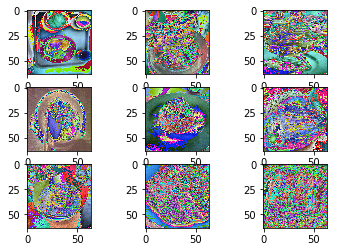

CPU times: user 8.52 s, sys: 1.16 s, total: 9.68 s
Wall time: 8.69 s


In [12]:
%%time
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### ZCA Whitening example

In [ ]:
%%time
# warning doesn't run on laptop
datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Random Rotation example

In [ ]:
%%time
datagen = ImageDataGenerator(rotation_range=90)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Random Shifts Example

In [ ]:
%%time
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Random Flips Example

In [ ]:
%%time
shift = 0.2
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Findings from image augmentation

The ZCA whitening process was suprisingly memory and computation intensive with an exponential cost as the resolution of the images were increased. 

### Image augmentation without ZCA

I had to change the pixel size to 128 due to lack of memory

In [9]:
def datagen_no_zca(train_tensors):
    datagen = ImageDataGenerator(
        featurewise_center=True, featurewise_std_normalization=True,
        zca_whitening=False,
        rotation_range=90,
        width_shift_range=0.2, height_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_tensors)
    return datagen

In [10]:
%%time
pixel_size = 128
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:15<00:00, 205.83it/s]


CPU times: user 2min 36s, sys: 3.97 s, total: 2min 40s
Wall time: 2min 39s


#### 3 Convolutional layers, 3 Pooling layers

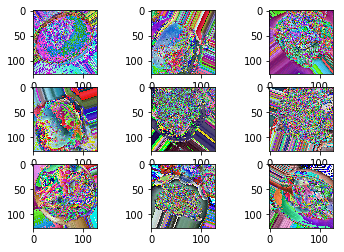

CPU times: user 31.1 s, sys: 3.04 s, total: 34.1 s
Wall time: 33.1 s


In [11]:
%%time
datagen = datagen_no_zca(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

In [13]:
no_zca_model_128 = Sequential()
num_conv_layers = 3
num_pool_layers = 3
no_zca_model_128.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(GlobalAveragePooling2D())
no_zca_model_128.add(Dense(num_food_labels, activation='softmax'))

In [16]:
%%time
# creates a simple model with augmentation minus zca
compile_run_test_with_datagen(   model=no_zca_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

#### 4 Convolutional layers, 4 Pooling layers

In [17]:
no_zca_model_128 = Sequential()
num_conv_layers = 4
num_pool_layers = 4
no_zca_model_128.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(GlobalAveragePooling2D())
no_zca_model_128.add(Dense(num_food_labels, activation='softmax'))

In [18]:
%%time
compile_run_test_with_datagen(model=no_zca_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       32896     
__________

#### 4 Convolutional layers, 4 Pooling layers, more nodes

In [19]:
no_zca_model_128 = Sequential()
num_conv_layers = 4
num_pool_layers = 4
no_zca_model_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(GlobalAveragePooling2D())
no_zca_model_128.add(Dense(num_food_labels, activation='softmax'))

In [ ]:
%%time
compile_run_test_with_datagen(model=no_zca_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.128.nodes')

### Image augmentation with ZCA

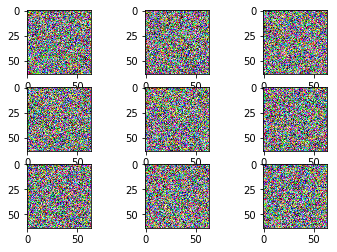

In [12]:
%%time
shift = 0.2
datagen = ImageDataGenerator(
    featurewise_center=True, featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=90,
    width_shift_range=shift, height_shift_range=shift,
    horizontal_flip=True, vertical_flip=True)

datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

In [ ]:
zca_model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
zca_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
zca_model.add(MaxPooling2D(pool_size=(2,2)))
zca_model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
zca_model.add(MaxPooling2D(pool_size=(2,2)))
zca_model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
zca_model.add(MaxPooling2D(pool_size=(2,2)))
zca_model.add(GlobalAveragePooling2D())
zca_model.add(Dense(num_food_labels, activation='softmax'))

In [ ]:
%%time
# create a basic result without augmentation but with 256 pixels
compile_run_test_with_datagen(
                    model=zca_model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20,
                    datagen=datagen)

In [ ]:
# Image augmentation, whitening, create base model, create advanced models, record results, use transfer learning
# Graphs visuals for results, diagram of architeture, sample images, show whitening process
# Do write up in pdf 9 -15 pages
# Write a readme
# contents page for ipython